✅ Cargando CSVs:
  - ./Atitlan_cyano_stats.csv
  - ./Amatitlan_cyano_stats.csv
Atitlán: (29, 3)  | Amatitlán: (19, 3)
Atitlan: 2025-02-07 → 2025-08-01 (≈ 175 días)
⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.
Amatitlan: 2025-02-07 → 2025-08-01 (≈ 175 días)
⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.


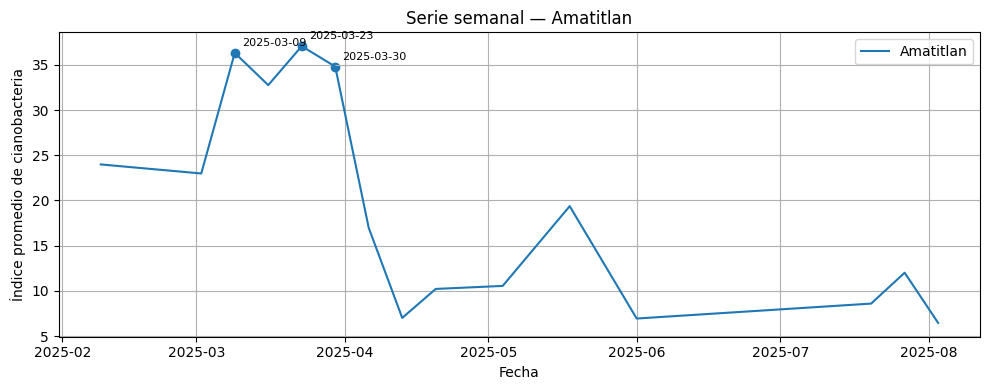

📈 Guardado: ./salidas_avance/figs/amatitlan_timeseries.png


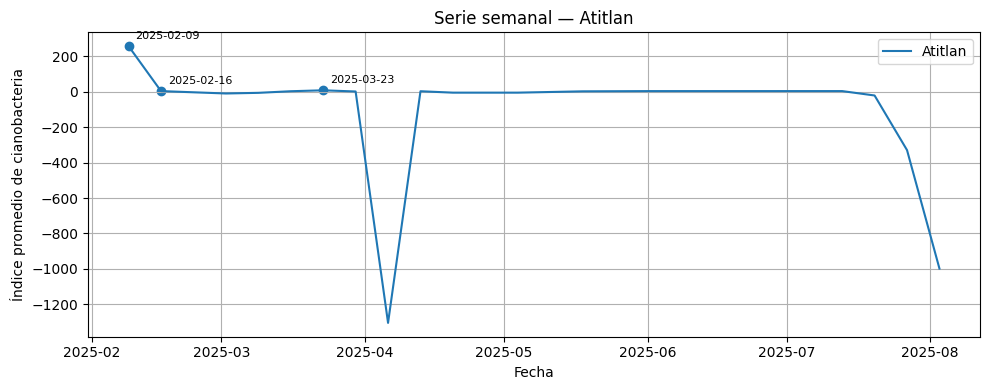

📈 Guardado: ./salidas_avance/figs/atitlan_timeseries.png


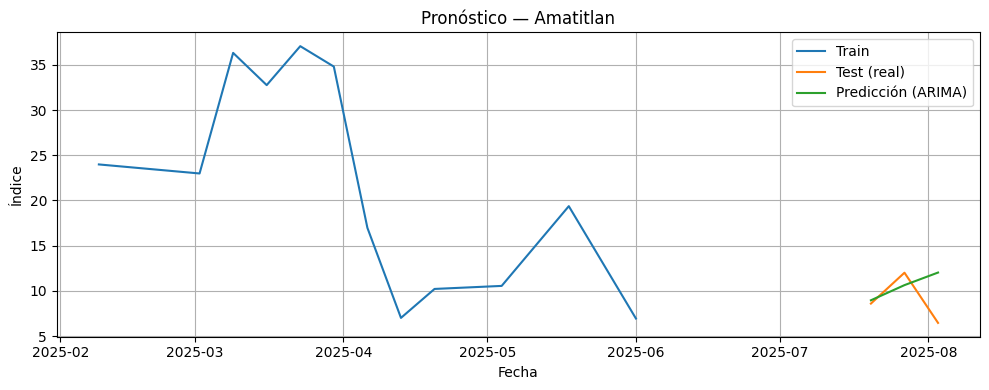

🤖 Guardado: ./salidas_avance/figs/amatitlan_forecast_test.png


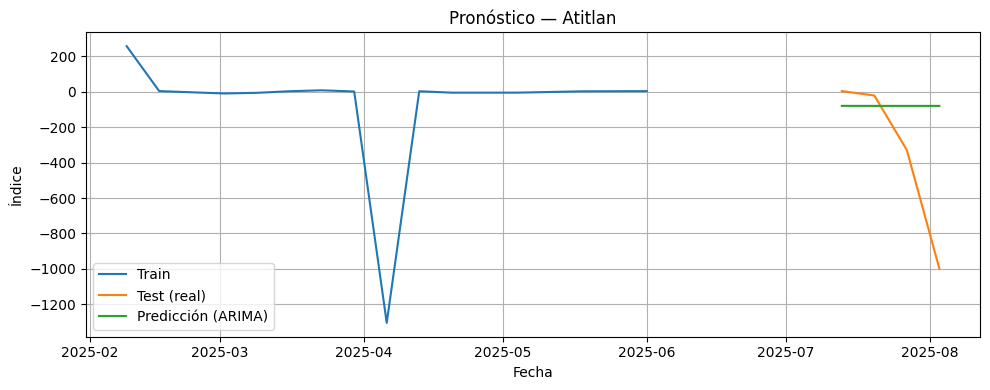

🤖 Guardado: ./salidas_avance/figs/atitlan_forecast_test.png

Métricas:


,lake,n_obs,model,MAE,RMSE,MAPE_%
0,Amatitlan,15,ARIMA,2.437468,3.319737,34.020540
1,Atitlan,17,ARIMA,327.777567,478.906749,626.153383



📦 Archivos exportados:
 - ./salidas_avance/avances_series_temporales_metrics.csv
 - ./salidas_avance/avances_series_temporales_predictions.csv
 - ./salidas_avance/avances_series_temporales_peaks.csv
 - ./salidas_avance/avances_resumen_tabla.csv


,lake,model,n_obs,MAE,RMSE,MAPE_%,Top3_Picos
0,Amatitlan,ARIMA,15,2.437468,3.319737,34.020540,2025-03-23 (≈37.079); 2025-03-09 (≈36.336); 20...
1,Atitlan,ARIMA,17,327.777567,478.906749,626.153383,2025-02-09 (≈257.804); 2025-03-23 (≈8.460); 20...


 - ./salidas_avance/avance_series_temporales_resumen.md

✅ Avance completo. Inserta las PNG de ./salidas_avance/figs en tu slide y copia el Markdown/tabla.


In [1]:
# ================================================================
# Avances – Series Temporales (Atitlán & Amatitlán)

# ================================================================


PATH_ATITLAN  = r"./Atitlan_cyano_stats.csv"
PATH_AMATITLAN= r"./Amatitlan_cyano_stats.csv"
PATH_MERGED   = r"./Lagos_cyano_stats_merged.csv"
OUT_DIR       = r"./salidas_avance"
OUT_FIGS      = OUT_DIR + "/figs"

# ---------------------------------------------------------------
import os, warnings, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from datetime import datetime

warnings.filterwarnings("ignore")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(OUT_FIGS, exist_ok=True)
plt.rcParams["figure.figsize"] = (10, 4)


try:
    from statsmodels.tsa.arima.model import ARIMA
except Exception:
    !{sys.executable} -m pip install -q statsmodels
    try:
        from statsmodels.tsa.arima.model import ARIMA
    except Exception:
        ARIMA = None
        print("⚠️ No fue posible importar statsmodels. Se usará solo el modelo Naive.")

# ---------- Utilidades ----------
def _normalize_two_cols(df, lake_name="", date_guess=("date","fecha","timestamp","time","acquisition_date")):
    cols = {c.lower(): c for c in df.columns}
    date_col = next((cols[k] for k in date_guess if k in cols), None)
    if date_col is None:
        raise ValueError("No se encontró columna de fecha (date/fecha/timestamp/time).")
    prefer = [f"{lake_name}_mean","cyano_mean","mean","indice","index","value"]
    idx_col = next((c for c in prefer if c in df.columns), None)
    if idx_col is None:
        nums = [c for c in df.columns if c != date_col and pd.api.types.is_numeric_dtype(df[c])]
        if not nums:
            raise ValueError("No se encontró columna numérica para el índice.")
        idx_col = nums[0]
    out = df[[date_col, idx_col]].copy()
    out.columns = ["date","value"]
    out["date"] = pd.to_datetime(out["date"])
    out["lake"] = lake_name
    return out.sort_values("date").reset_index(drop=True)

def _from_merged(dfm):
    cols = {c.lower(): c for c in dfm.columns}
    c_date = next((cols[k] for k in ("date","fecha","timestamp","time") if k in cols), None)
    c_lake = next((cols[k] for k in ("lake","lago") if k in cols), None)
    c_val  = next((cols[k] for k in ("value","valor","indice","index","mean","cyano_mean") if k in cols), None)

    # Formato largo
    if c_date and c_lake and c_val:
        t = dfm[[c_date, c_lake, c_val]].copy()
        t.columns = ["date","lake","value"]
        t["date"] = pd.to_datetime(t["date"])
        t["lake"] = t["lake"].astype(str).str.strip().str.title()
        t = t[t["lake"].isin(["Atitlan","Amatitlan","Atitlán","Amatitlán"])].copy()
        t["lake"] = t["lake"].replace({"Atitlán":"Atitlan","Amatitlán":"Amatitlan"})
        dfa = t[t["lake"]=="Atitlan"][["date","value"]].copy(); dfa["lake"]="Atitlan"
        dfb = t[t["lake"]=="Amatitlan"][["date","value"]].copy(); dfb["lake"]="Amatitlan"
        return dfa.reset_index(drop=True), dfb.reset_index(drop=True)

    # Formato ancho
    if c_date:
        wide_cols = [c for c in dfm.columns if "atitlan" in c.lower() or "amatitlan" in c.lower()]
        if len(wide_cols) >= 2:
            dfw = dfm.copy()
            dfw[c_date] = pd.to_datetime(dfw[c_date])
            melted = dfw.melt(id_vars=[c_date], var_name="lake", value_name="value")
            melted["lake"] = melted["lake"].str.extract(r"(Atitlan|Amatitlan)", expand=False).fillna(melted["lake"])
            melted.columns = ["date","lake","value"]
            melted = melted.dropna(subset=["value"])
            dfa = melted[melted["lake"].str.contains("Atitlan", case=False)][["date","value"]].copy(); dfa["lake"]="Atitlan"
            dfb = melted[melted["lake"].str.contains("Amatitlan", case=False)][["date","value"]].copy(); dfb["lake"]="Amatitlan"
            return dfa.reset_index(drop=True), dfb.reset_index(drop=True)

    raise ValueError("No reconozco el formato del archivo 'merged'. Revisa nombres de columnas.")

def load_data():

    local = globals()
    if "df_atitlan" in local and "df_amatitlan" in local:
        print("✅ Usando df_atitlan / df_amatitlan en memoria.")
        return local["df_atitlan"].copy(), local["df_amatitlan"].copy()

    # 2) CSV individuales
    if os.path.exists(PATH_ATITLAN) and os.path.exists(PATH_AMATITLAN):
        print(f"✅ Cargando CSVs:\n  - {PATH_ATITLAN}\n  - {PATH_AMATITLAN}")
        dfa = _normalize_two_cols(pd.read_csv(PATH_ATITLAN), lake_name="Atitlan")
        dfb = _normalize_two_cols(pd.read_csv(PATH_AMATITLAN), lake_name="Amatitlan")
        return dfa, dfb

    # 3) CSV unificado (merged)
    if os.path.exists(PATH_MERGED):
        print(f"✅ Cargando CSV unificado: {PATH_MERGED}")
        dfa, dfb = _from_merged(pd.read_csv(PATH_MERGED))
        return dfa, dfb

    # 4) Convenciones de nombre
    for a,b in [("Atitlan_cyano_stats.csv","Amatitlan_cyano_stats.csv"),
                ("./Atitlan_cyano_stats.csv","./Amatitlan_cyano_stats.csv")]:
        if os.path.exists(a) and os.path.exists(b):
            print(f"✅ Cargando CSVs por nombre convencional:\n  - {a}\n  - {b}")
            dfa = _normalize_two_cols(pd.read_csv(a), lake_name="Atitlan")
            dfb = _normalize_two_cols(pd.read_csv(b), lake_name="Amatitlan")
            return dfa, dfb

    raise FileNotFoundError("No encuentro datos. Descarga de Drive y ajusta PATH_ATITLAN / PATH_AMATITLAN o PATH_MERGED arriba.")

def span_days(df):
    return (df["date"].max() - df["date"].min()).days

def resample_weekly(df):
    dfr = df.set_index("date").resample("W").mean(numeric_only=True)
    dfr["lake"] = df["lake"].iloc[0]
    return dfr.reset_index().dropna(subset=["value"])

def detect_peaks(g, k=3):
    return g.sort_values("value", ascending=False).head(k)[["date","value"]]

def mae(y_true, y_pred):  return float(np.mean(np.abs(np.array(y_true)-np.array(y_pred))))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((np.array(y_true)-np.array(y_pred))**2)))
def mape(y_true, y_pred):
    y_true = np.array(y_true); y_pred = np.array(y_pred); eps=1e-9
    return float(np.mean(np.abs((y_true - y_pred)/ (np.abs(y_true)+eps))) * 100)

def fit_predict_arima(series):
    if ARIMA is None:
        return None
    for order in [(1,1,1),(1,0,1)]:
        try:
            model = ARIMA(series, order=order).fit()
            return model
        except Exception:
            continue
    return None

# ---------- 1) Carga de datos ----------
df_atitlan_raw, df_amatitlan_raw = load_data()
print("Atitlán:", df_atitlan_raw.shape, " | Amatitlán:", df_amatitlan_raw.shape)

# ---------- 2) Validación de ventana (≥ 6 meses) ----------
for lake, g in [("Atitlan", df_atitlan_raw), ("Amatitlan", df_amatitlan_raw)]:
    days = span_days(g)
    print(f"{lake}: {g['date'].min().date()} → {g['date'].max().date()} (≈ {days} días)")
    if days < 180:
        print("⚠️ Atención: periodo < 6 meses. Considera ampliar la ventana temporal.")

# ---------- 3) Resample semanal ----------
ts_atitlan  = resample_weekly(df_atitlan_raw)
ts_amatitlan= resample_weekly(df_amatitlan_raw)
ts_weekly   = pd.concat([ts_atitlan, ts_amatitlan], ignore_index=True)

# ---------- 4) Gráficas de serie + picos ----------
for lake, g in ts_weekly.groupby("lake"):
    g = g.sort_values("date")
    peaks = detect_peaks(g, k=3)
    plt.figure()
    plt.plot(g["date"], g["value"], label=lake)
    plt.scatter(peaks["date"], peaks["value"])
    for _, r in peaks.iterrows():
        plt.annotate(str(pd.to_datetime(r["date"]).date()), (r["date"], r["value"]),
                     xytext=(5,5), textcoords="offset points", fontsize=8)
    plt.title(f"Serie semanal — {lake}")
    plt.xlabel("Fecha"); plt.ylabel("Índice promedio de cianobacteria")
    plt.grid(True); plt.legend(); plt.tight_layout()
    out = os.path.join(OUT_FIGS, f"{lake.lower()}_timeseries.png")
    plt.savefig(out, dpi=200); plt.show()
    print("📈 Guardado:", out)

# ---------- 5) Modelado (ARIMA -> Naive) ----------
metrics = []
predictions_store = []

for lake, g in ts_weekly.groupby("lake"):
    g = g.sort_values("date").reset_index(drop=True)
    y = g["value"].values
    n = len(y)
    split = max(1, int(n*0.8)) if n >= 12 else max(1, int(n*0.8))

    y_train, y_test = y[:split], y[split:]
    d_train, d_test = g["date"][:split], g["date"][split:]

    model = fit_predict_arima(y_train)
    if model is not None:
        try:
            y_pred = np.asarray(model.forecast(steps=len(y_test)))
            used_model = "ARIMA"
        except Exception:
            y_pred = np.repeat(y_train[-1], len(y_test))
            used_model = "Naive (fallback)"
    else:
        y_pred = np.repeat(y_train[-1], len(y_test))
        used_model = "Naive"

    lake_mae  = mae(y_test, y_pred) if len(y_test)>0 else np.nan
    lake_rmse = rmse(y_test, y_pred) if len(y_test)>0 else np.nan
    lake_mape = mape(y_test, y_pred) if len(y_test)>0 else np.nan

    metrics.append({"lake": lake, "n_obs": n, "model": used_model,
                    "MAE": lake_mae, "RMSE": lake_rmse, "MAPE_%": lake_mape})

    # plot test
    if len(y_test) > 0:
        plt.figure()
        plt.plot(d_train, y_train, label="Train")
        plt.plot(d_test,  y_test,  label="Test (real)")
        plt.plot(d_test,  y_pred,  label=f"Predicción ({used_model})")
        plt.title(f"Pronóstico — {lake}")
        plt.xlabel("Fecha"); plt.ylabel("Índice"); plt.grid(True); plt.legend(); plt.tight_layout()
        out = os.path.join(OUT_FIGS, f"{lake.lower()}_forecast_test.png")
        plt.savefig(out, dpi=200); plt.show()
        print("🤖 Guardado:", out)

    # guardar predicciones de test
    df_pred_test = pd.DataFrame({"date": d_test.values, "lake": lake,
                                 "y_true": y_test, "y_pred": y_pred})
    predictions_store.append(df_pred_test)

    # pronóstico 4 semanas adelante
    if ARIMA is not None and used_model.startswith("ARIMA"):
        try:
            model_full = fit_predict_arima(y)
            fc_future = np.asarray(model_full.forecast(steps=4))
        except Exception:
            fc_future = np.repeat(y[-1], 4)
    else:
        fc_future = np.repeat(y[-1], 4)
    future_dates = pd.date_range(start=g["date"].iloc[-1] + pd.Timedelta(days=7), periods=4, freq="W")
    predictions_store.append(pd.DataFrame({"date": future_dates, "lake": lake, "forecast": fc_future}))

metrics_df = pd.DataFrame(metrics)
print("\nMétricas:")
display(metrics_df)

# ---------- 6) Exportar CSVs ----------
metrics_path = os.path.join(OUT_DIR, "avances_series_temporales_metrics.csv")
preds_path   = os.path.join(OUT_DIR, "avances_series_temporales_predictions.csv")
peaks_path   = os.path.join(OUT_DIR, "avances_series_temporales_peaks.csv")

# reconstruir peaks_report para exportar
peaks_list = []
for lake, g in ts_weekly.groupby("lake"):
    p = detect_peaks(g, 3).copy()
    p["lake"] = lake
    peaks_list.append(p)
peaks_report = pd.concat(peaks_list, ignore_index=True)

metrics_df.to_csv(metrics_path, index=False)
pd.concat(predictions_store, ignore_index=True).to_csv(preds_path, index=False)
peaks_report.to_csv(peaks_path, index=False)

print("\n📦 Archivos exportados:")
print(" -", metrics_path)
print(" -", preds_path)
print(" -", peaks_path)

# ---------- 7) Resumen para slide ----------
# Top-3 picos en una línea
peaks_txt = (
    peaks_report.sort_values(["lake","value"], ascending=[True, False])
    .groupby("lake")
    .apply(lambda d: "; ".join([f"{pd.to_datetime(r.date).date()} (≈{r.value:.3f})"
                                for r in d.head(3).itertuples()]))
    .rename("Top3_Picos").reset_index()
)
summary = metrics_df.merge(peaks_txt, on="lake", how="left")[["lake","model","n_obs","MAE","RMSE","MAPE_%","Top3_Picos"]]
summary_path = os.path.join(OUT_DIR, "avances_resumen_tabla.csv")
summary.to_csv(summary_path, index=False)
print(" -", summary_path)
display(summary)

# ---------- 8) Mini-informe Markdown ----------
md_lines = [
    "# Avance — Series Temporales (Atitlán & Amatitlán)",
    f"_Fecha de ejecución: {datetime.now():%Y-%m-%d %H:%M}_",
    "",
    "## Resultados clave",
]
for _, r in summary.iterrows():
    md_lines.append(f"- **{r['lake']}** — Modelo: {r['model']}. "
                    f"MAE={r['MAE']:.4f}, RMSE={r['RMSE']:.4f}, MAPE={r['MAPE_%']:.2f}%. "
                    f"Top picos: {r['Top3_Picos']}")

md_lines += [
    "",
    "## Observaciones",
    "- Ventana temporal: revisar rangos impresos en consola (≥ 6 meses recomendado).",
    "- Picos: validar coincidencias entre lagos y posibles factores (lluvias, descargas, nubosidad residual).",
    "- ARIMA se usa como baseline; si la serie es corta/no estacionaria, se aplica Naive.",
    "",
    "## Próximos pasos",
    "1. Correlación con NDVI/NDWI.",
    "2. Clasificación binaria (alto/normal) por fecha/área.",
    "3. Modelo híbrido (pronóstico → clasificación) y mapas de proyección en Folium.",
]
md_path = os.path.join(OUT_DIR, "avance_series_temporales_resumen.md")
with open(md_path, "w", encoding="utf-8") as f:
    f.write("\n".join(md_lines))
print(" -", md_path)

print("\n✅ Avance completo. Inserta las PNG de ./salidas_avance/figs en tu slide y copia el Markdown/tabla.")
